# 0. Install Dependencies and Bring in Data

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
df = pd.read_csv(os.path.join('preprocessed_indonesian_toxic_tweet.csv'))

In [4]:
df.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,di saat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,siapa yang telat memberi tau kamu edan sarap ...,0,1,0,0,0,0,0,0,0,0,0,0
2,41 kadang aku berpikir kenapa aku tetap percay...,0,0,0,0,0,0,0,0,0,0,0,0
3,aku itu aku dan ku tau matamu sipit tapi dili...,0,0,0,0,0,0,0,0,0,0,0,0
4,kaum cebong kafir sudah kelihatan dongoknya d...,1,1,0,1,1,0,0,0,0,0,1,0


In [5]:
df.shape

(13169, 13)

# 1. Preprocess

In [6]:
!pip list

Package                       Version
----------------------------- -----------
absl-py                       1.4.0
aiofiles                      23.1.0
aiohttp                       3.8.4
aiosignal                     1.3.1
altair                        5.0.0
anyio                         3.6.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
asttokens                     2.2.1
astunparse                    1.6.3
async-timeout                 4.0.2
attrs                         23.1.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.12.2
bleach                        6.0.0
blinker                       1.6.2
cachetools                    5.3.0
certifi                       2023.5.7
cffi                          1.15.1
charset-normalizer            3.1.0
click                         8.1.3
colorama                      0.4.6
comm                          0.1.3
contourpy                     1.0.7
cycler     

In [7]:
from tensorflow.keras.layers import TextVectorization

In [8]:
X = df['Tweet']
y = df[df.columns[1:]].values

In [9]:
df[df.columns[1:]]

,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,1,1,1,0,0,0,0,0,1,1,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
13164,1,1,1,0,0,0,1,0,0,1,0,0
13165,0,1,0,0,0,0,0,0,0,0,0,0
13166,0,0,0,0,0,0,0,0,0,0,0,0
13167,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
MAX_FEATURES = 200000 # number of words in the vocab

In [11]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [12]:
vectorizer.adapt(X.values)

In [13]:
vectorized_text = vectorizer(X.values)

In [14]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [15]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [16]:
train_size = len(test)
print("Jumlah data pelatihan:", train_size)

Jumlah data pelatihan: 82


# 2. Create Sequential Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [18]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(12, activation='sigmoid'))

In [19]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 12)                1548      
                                                        

In [21]:
history = model.fit(train, epochs=100, validation_data=val)

Epoch 1/100
576/576 [==============================] - 162s 273ms/step - loss: 0.3422 - val_loss: 0.2585
Epoch 2/100
576/576 [==============================] - 163s 283ms/step - loss: 0.2396 - val_loss: 0.1972
Epoch 3/100
576/576 [==============================] - 168s 292ms/step - loss: 0.1982 - val_loss: 0.1702
Epoch 4/100
576/576 [==============================] - 177s 307ms/step - loss: 0.1729 - val_loss: 0.1543
Epoch 5/100
576/576 [==============================] - 173s 300ms/step - loss: 0.1517 - val_loss: 0.1248
Epoch 6/100
576/576 [==============================] - 175s 305ms/step - loss: 0.1283 - val_loss: 0.1106
Epoch 7/100
576/576 [==============================] - 178s 308ms/step - loss: 0.1079 - val_loss: 0.0943
Epoch 8/100
576/576 [==============================] - 176s 305ms/step - loss: 0.0980 - val_loss: 0.0820
Epoch 9/100
576/576 [==============================] - 174s 303ms/step - loss: 0.0817 - val_loss: 0.0658
Epoch 10/100
576/576 [==============================] -

In [22]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

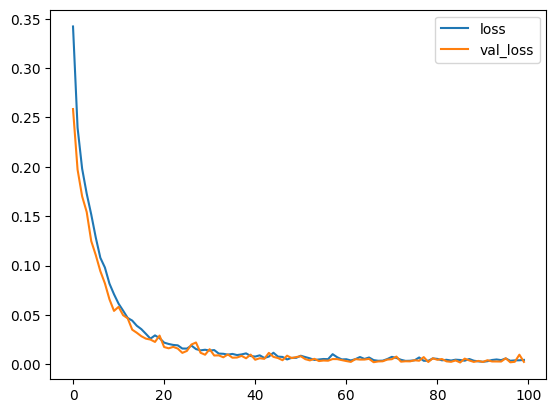

In [23]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [24]:
input_text = vectorizer(['siapa suruh kesana lo, kena korupsi kan?'])

In [25]:
res = model.predict(input_text)

In [26]:
(res > 0.5).astype(int)

array([[1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]])

In [27]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [28]:
(model.predict(batch_X) > 0.5).astype(int)

array([[1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [29]:
res.shape

(1, 12)

# 4. Evaluate Model

In [30]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [31]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [32]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [33]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9971191883087158, Recall:0.9974783658981323, Accuracy:0.5853658318519592


# 5. Test menggunakan Gradio

In [ ]:
!pip install gradio jinja2

In [34]:
import tensorflow as tf
import gradio as gr

In [35]:
model.save('toxicity.h5')

In [36]:
model = tf.keras.models.load_model('toxicity.h5')

In [37]:
input_str = vectorizer('apaan lu, uda gaya gayaan, mau gua tabok lu anying?')

In [38]:
res = model.predict(np.expand_dims(input_str,0))

In [39]:
res

array([[1.0000000e+00, 1.3270355e-03, 9.9999988e-01, 1.1636804e-09,
        1.3071178e-06, 2.4640795e-07, 1.5329601e-06, 1.2621786e-08,
        9.9997950e-01, 9.9999750e-01, 1.7171398e-09, 6.0960978e-09]],
      dtype=float32)

In [40]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [41]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

C:\Users\HP\miniconda3\envs\tf\lib\site-packages\gradio\inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\HP\miniconda3\envs\tf\lib\site-packages\gradio\inputs.py:30: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
C:\Users\HP\miniconda3\envs\tf\lib\site-packages\gradio\inputs.py:30: UserWarning: `numeric` parameter is deprecated, and it has no effect
  super().__init__(


In [42]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://6da52737155e79e550.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
